In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [47]:
# Load the dataset (assuming it is a CSV file)
data = pd.read_csv('survey_results_public.csv')

# Display the first few rows of the dataset
print(data.head())


   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

In [48]:
# Check for missing values
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage Missing': missing_percentage})
print(missing_data.sort_values(by='Percentage Missing', ascending=False))

# Drop features with more than 60% missing values
threshold = 60
data_cleaned = data.drop(columns=missing_data[missing_data['Percentage Missing'] > threshold].index)




                            Missing Values  Percentage Missing
AINextMuch less integrated           64289           98.245641
AINextLess integrated                63082           96.401119
AINextNo change                      52939           80.900714
AINextMuch more integrated           51999           79.464217
EmbeddedAdmired                      48704           74.428840
...                                    ...                 ...
MainBranch                               0            0.000000
Check                                    0            0.000000
Employment                               0            0.000000
Age                                      0            0.000000
ResponseId                               0            0.000000

[114 rows x 2 columns]


In [49]:
# Check again for remaining missing values
print(data_cleaned.isnull().sum())

ResponseId             0
MainBranch             0
Age                    0
Employment             0
RemoteWork         10631
                   ...  
JobSatPoints_10    35987
JobSatPoints_11    35992
SurveyLength        9255
SurveyEase          9199
JobSat             36311
Length: 104, dtype: int64


In [50]:
# Display the first few rows to understand the data structure
print(data.head())

# Check for missing values in the dataset
print(data.isnull().sum())

# Check data types of each column
print(data.dtypes)

# Summary statistics for numerical columns
print(data.describe())

   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

In [51]:
# Check percentage of missing values in the JobSat column
missing_target_percentage = (data_cleaned['JobSat'].isnull().sum() / len(data_cleaned)) * 100
print(f"Missing values in target (JobSat): {missing_target_percentage:.2f}%")


Missing values in target (JobSat): 55.49%


In [41]:
# Check for missing values in the target column (JobSat)
print(data_cleaned['JobSat'].isnull().sum())

# Drop rows where JobSat (target variable) is missing
data_cleaned = data_cleaned.dropna(subset=['JobSat'])

# Now split the data into training and testing sets before encoding
X = data_cleaned[['Age', 'Employment', 'RemoteWork', 'EdLevel', 'CodingActivities']]
y = data_cleaned['JobSat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder column-wise on training data
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.columns:
    # Fit on training data
    le.fit(X_train_encoded[col])
    
    # Transform both training and test data with the same encoder
    X_train_encoded[col] = le.transform(X_train_encoded[col])
    
    # For the test set, apply transform only on known labels, handle unseen labels with a fallback
    X_test_encoded[col] = X_test_encoded[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Now you can proceed to model training and evaluation


36311


In [44]:
X_test_encoded

,Age,Employment,RemoteWork,EdLevel,CodingActivities
43178,0,0,0,1,30
42326,2,32,2,1,8
19857,1,0,1,2,29
9394,1,0,0,1,81
22558,2,0,2,1,42
...,...,...,...,...,...
20129,1,2,0,1,82
48627,1,0,0,1,81
51642,1,0,2,0,39
13959,2,32,2,2,62


In [40]:
# Import RandomForestClassifier and fit it to the encoded training data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Train the model on the encoded training set
rf.fit(X_train_encoded, y_train)


ValueError: Input y contains NaN.

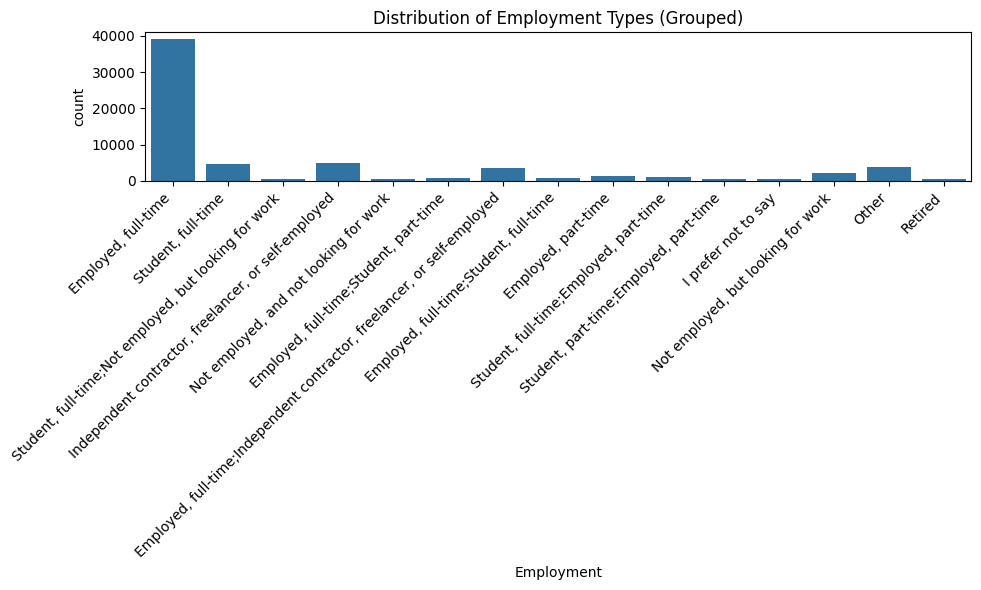

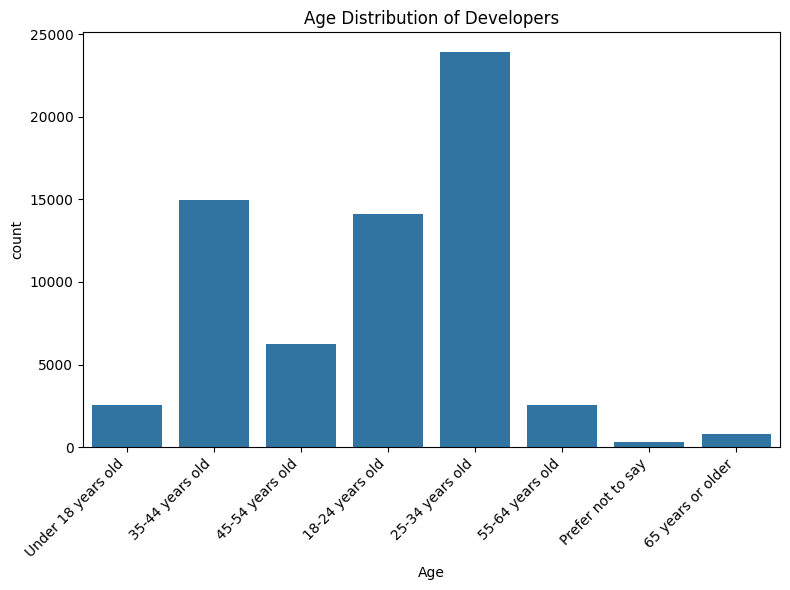

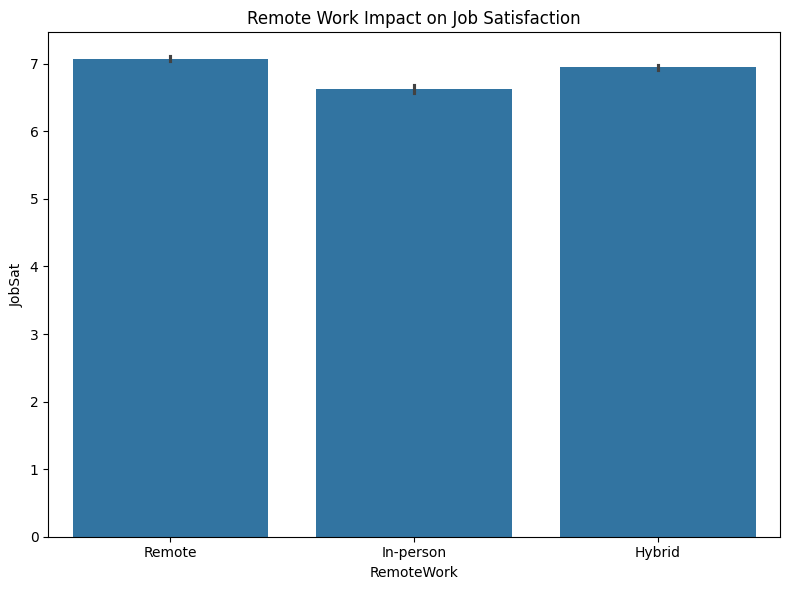

In [12]:
# Group less frequent employment types into 'Other'
employment_counts = data['Employment'].value_counts()
rare_employment_types = employment_counts[employment_counts < 500].index
data['Employment'] = data['Employment'].replace(rare_employment_types, 'Other')

# Plot the cleaned Employment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Employment', data=data)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Employment Types (Grouped)')
plt.tight_layout()
plt.show()


# Plot Age Distribution with rotated labels and adjusted figure size
plt.figure(figsize=(8, 6))
sns.countplot(x='Age', data=data)
plt.xticks(rotation=45, ha='right')
plt.title('Age Distribution of Developers')
plt.tight_layout()
plt.show()


# Shorten category names for Remote Work
data['RemoteWork'] = data['RemoteWork'].replace({
    'Hybrid (some remote, some in-person)': 'Hybrid',
    'In-person': 'In-person',
    'Remote': 'Remote'
})

# Plot Remote Work vs Job Satisfaction with shortened labels
plt.figure(figsize=(8, 6))
sns.barplot(x='RemoteWork', y='JobSat', data=data)
plt.title('Remote Work Impact on Job Satisfaction')
plt.tight_layout()
plt.show()


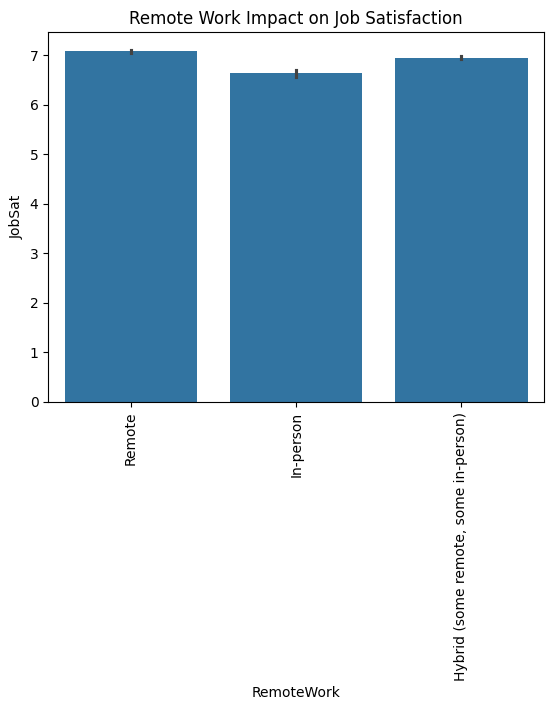

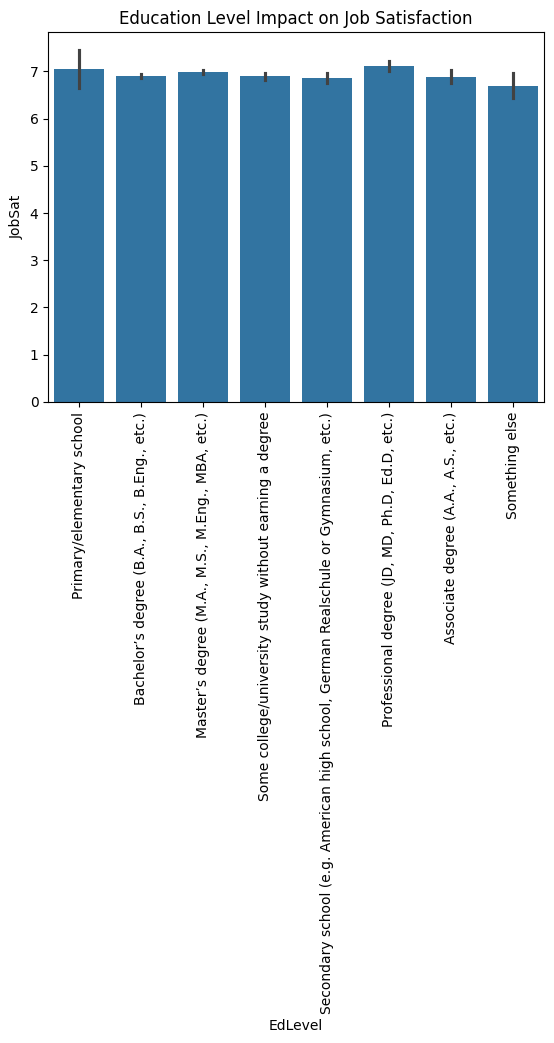

In [9]:
# Barplot of Remote Work vs Job Satisfaction
sns.barplot(x='RemoteWork', y='JobSat', data=data)
plt.xticks(rotation=90)
plt.title('Remote Work Impact on Job Satisfaction')
plt.show()

# Barplot for Education Level
sns.barplot(x='EdLevel', y='JobSat', data=data)
plt.xticks(rotation=90)
plt.title('Education Level Impact on Job Satisfaction')
plt.show()


   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

In [15]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (missing_values / len(data)) * 100

# Combine into a DataFrame for better visualization
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentage
})

# Sort by percentage of missing values
missing_data_sorted = missing_data.sort_values(by='Percentage Missing', ascending=False)
print(missing_data_sorted)


                            Missing Values  Percentage Missing
AINextMuch less integrated           64289           98.245641
AINextLess integrated                63082           96.401119
AINextNo change                      52939           80.900714
AINextMuch more integrated           51999           79.464217
EmbeddedAdmired                      48704           74.428840
...                                    ...                 ...
MainBranch                               0            0.000000
Check                                    0            0.000000
Employment                               0            0.000000
Age                                      0            0.000000
ResponseId                               0            0.000000

[114 rows x 2 columns]


In [17]:
# Remove features with more than 70% missing data
threshold = 70  # You can adjust this threshold
features_to_drop = missing_data_sorted[missing_data_sorted['Percentage Missing'] > threshold].index
data_cleaned = data.drop(columns=features_to_drop)

# Check the cleaned dataset
print(data_cleaned.head())


   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

In [24]:
# Step 1: Convert Age ranges to numeric values
age_mapping = {
    'Under 18 years old': 17,
    '18-24 years old': 21,
    '25-34 years old': 30,  # Integer midpoint approximation
    '35-44 years old': 40,
    '45-54 years old': 50,
    '55-64 years old': 60,
    '65 years or older': 70,
    'Prefer not to say': None  # Treat this as missing
}

# Replace Age ranges with numeric values
data_cleaned['Age'] = data_cleaned['Age'].replace(age_mapping)

# Step 2: Impute missing values for Age using the median
data_cleaned['Age'].fillna(data_cleaned['Age'].median(), inplace=True)

# Step 3: Impute missing values for CodingActivities using the mode (most frequent value)
data_cleaned['CodingActivities'].fillna(data_cleaned['CodingActivities'].mode()[0], inplace=True)

# Now both 'Age' and 'CodingActivities' columns have been handled for missing values.


C:\Users\msn\AppData\Local\Temp\ipykernel_1676\3171532921.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Age'].fillna(data_cleaned['Age'].median(), inplace=True)
C:\Users\msn\AppData\Local\Temp\ipykernel_1676\3171532921.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

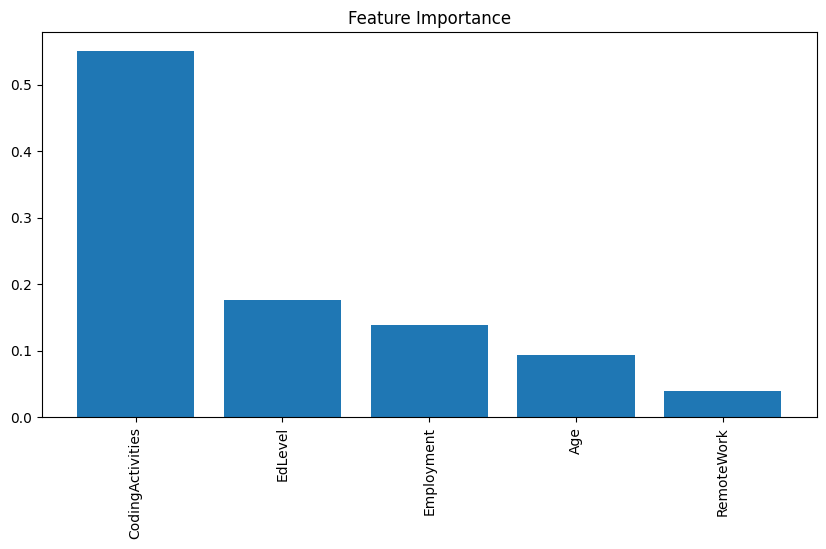

In [25]:
# Drop rows where the target variable 'JobSat' is missing
data_cleaned = data.dropna(subset=['JobSat'])

# Now proceed with feature selection and encoding
X = data_cleaned[['Age', 'Employment', 'RemoteWork', 'EdLevel', 'CodingActivities']]
y = data_cleaned['JobSat']

# Label encoding for categorical features
le = LabelEncoder()
X_encoded = X.apply(le.fit_transform)

# Random Forest feature importance
rf = RandomForestClassifier()
rf.fit(X_encoded, y)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.bar(range(X_encoded.shape[1]), importances[indices])
plt.xticks(range(X_encoded.shape[1]), X.columns[indices], rotation=90)
plt.title('Feature Importance')
plt.show()


In [27]:
# Check for missing values in the target column (JobSat)
print(data_cleaned['JobSat'].isnull().sum())


0


In [28]:
# Drop rows where JobSat (target variable) is missing
data_cleaned = data_cleaned.dropna(subset=['JobSat'])

# Split features and target again after cleaning
X = data_cleaned[['Age', 'Employment', 'RemoteWork', 'EdLevel', 'CodingActivities']]
y = data_cleaned['JobSat']

# Encode categorical features
le = LabelEncoder()
X_encoded = X.apply(le.fit_transform)

# Now you can fit the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_encoded, y)


RandomForestClassifier()

In [26]:
# Feature selection
X = data[['Age', 'Employment', 'RemoteWork', 'EdLevel', 'CodingActivities']]
y = data['JobSat']

# Label encoding for categorical features
le = LabelEncoder()
X_encoded = X.apply(le.fit_transform)

# Random Forest feature importance
rf = RandomForestClassifier()
rf.fit(X_encoded, y)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.bar(range(X_encoded.shape[1]), importances[indices])
plt.xticks(range(X_encoded.shape[1]), X.columns[indices], rotation=90)
plt.title('Feature Importance')
plt.show()


ValueError: Input y contains NaN.